In [17]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, skew
from sklearn.metrics import confusion_matrix
from seaborn import heatmap


In [2]:
def disp2vel(disp,dt):
    vel = np.zeros(disp.shape)
    vel[:,1:] = (disp[:,1:]-disp[:,0:-1])/dt
    vel[:,0] = -2*vel[:,0]+vel[:,1]
    return vel

def vel2acc(vel,dt):
    acc = np.zeros(vel.shape)
    acc[:,1:] = (vel[:,1:]-vel[:,0:-1])/dt
    acc[:,0] = -2*acc[:,0]+acc[:,1]
    return acc

def acc2vel(acc,dt):
    vel = np.zeros(acc.shape)
    for i in range(0,vel.shape[1]-1):
        vel[:,i+1] = vel[:,i]+1/2*(acc[:,i+1]+acc[:,i])*dt
    print(i)
    return vel

def vel2disp(vel,dt):
    disp = np.zeros(vel.shape)
    for i in range(1,disp.shape[1]-1):
        disp[:,i+1] = disp[:,i]+1/2*(vel[:,i+1]+vel[:,i])*dt
    return disp

In [3]:
mat = scipy.io.loadmat('test2010.mat')

In [4]:
chan_names = mat['chan_names']
data = mat['data']


In [5]:
D = 0.027

t1 = 15
t2 = 165
Fs = 1200
dt = 1/Fs
tst = t1*Fs
ted = t2*Fs

nm = data.shape[1]
time = np.arange(0,nm-1)*dt
time = time[tst:ted].reshape(1,-1)

strain_CF = data[46:70,tst:ted]
strain_IL = data[6:46,tst:ted]
pos_IL = data[98:106,tst:ted]
pos_CF = data[106:114,tst:ted]
acc_IL = data[70:78,tst:ted]
acc_CF = data[78:86,tst:ted]

# Strain sensor positions
str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                     15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                     28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
str_cf = str_il[str_sensor_cf]

# Accelerometer positions
acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

#vel_CF = disp2vel(pos_CF,dt)
#acc_CF = vel2acc(vel_CF,dt)

#vel_IL = disp2vel(pos_IL,dt)
#acc_IL = vel2acc(vel_IL,dt)

vel_CF = acc2vel(acc_CF,dt)
disp_CF = vel2disp(vel_CF,dt)

179998


In [6]:
# Finding indices for strain locations whihc will be fused 
sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)

sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

In [7]:
#X = np.vstack((time,pos_IL,pos_CF,vel_IL,vel_CF,acc_IL,acc_CF)).transpose()
X = np.vstack((time,acc_IL,acc_CF)).transpose()
#Y = np.vstack((strain_CF.argmax(axis=0),strain_IL.argmax(axis=0))).transpose()
Y = np.vstack((strain_CF.argmax(axis=0))).transpose()
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
#Y = (Y-Y.min())/(Y.max()-Y.min())

n_features = X.shape[1]
b_size = 100
n_outputs = Y.shape[0]

n_batches = int(X.shape[0]/b_size)
X = X.reshape(n_batches,b_size,n_features)
Y = Y.reshape(n_batches,b_size,n_outputs)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=False)

t_train = X_train[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,0:-1]
X_test = X_test[:,:,0:-1]

n_features = n_features-1
n_outputs = Y.max()+1

In [22]:
model = Sequential(name='LSTM')
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0,
    recurrent_dropout=0))
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0))
model.add(Dense(n_outputs, activation='softmax'))
model.add(MaxPooling1D(pool_size=1))

model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['SparseCategoricalAccuracy'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 100)          46800     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dense_6 (Dense)              (None, 100, 50)           5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 100, 24)           1224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 24)           0         
Total params: 133,474
Trainable params: 133,474
Non-trainable params: 0
________________________________________________________

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback)

Epoch 1/100
38/38 [==============================] - 6s 67ms/step - loss: 2.8175 - sparse_categorical_accuracy: 0.1786
Epoch 2/100
38/38 [==============================] - 3s 67ms/step - loss: 2.2367 - sparse_categorical_accuracy: 0.3199: 0s - loss: 2.2367 - sparse_categorical_accuracy: 0.319
Epoch 3/100
38/38 [==============================] - 3s 75ms/step - loss: 1.9929 - sparse_categorical_accuracy: 0.3924
Epoch 4/100
38/38 [==============================] - 4s 98ms/step - loss: 1.8558 - sparse_categorical_accuracy: 0.4270
Epoch 5/100
38/38 [==============================] - 4s 101ms/step - loss: 1.7513 - sparse_categorical_accuracy: 0.4474
Epoch 6/100
38/38 [==============================] - 4s 105ms/step - loss: 1.6706 - sparse_categorical_accuracy: 0.4677
Epoch 7/100
38/38 [==============================] - 4s 111ms/step - loss: 1.5989 - sparse_categorical_accuracy: 0.4867
Epoch 8/100
38/38 [==============================] - 4s 117ms/step - loss: 1.5353 - sparse_categorical_accur

In [11]:
model.save('RNN_01')

INFO:tensorflow:Assets written to: RNN_01\assets


INFO:tensorflow:Assets written to: RNN_01\assets


In [24]:
y_pred = model.predict(X_test)
y_pred=y_pred.argmax(axis=2)

In [43]:
y_pred[0,0]

8

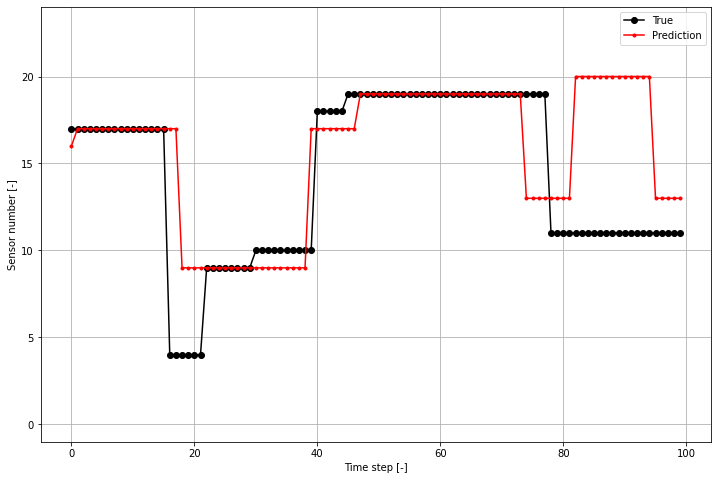

In [56]:
n = 3
plt.figure(figsize=(12,8))
plt.plot(y_test[n,:],'ko-',label='True')
plt.plot(y_pred[n,:],'r.-',label='Prediction')

plt.legend()
plt.grid()
plt.ylim([-1,24])
plt.ylabel('Sensor number [-]')
plt.xlabel('Time step [-]')
plt.show()

0.5678451178451178


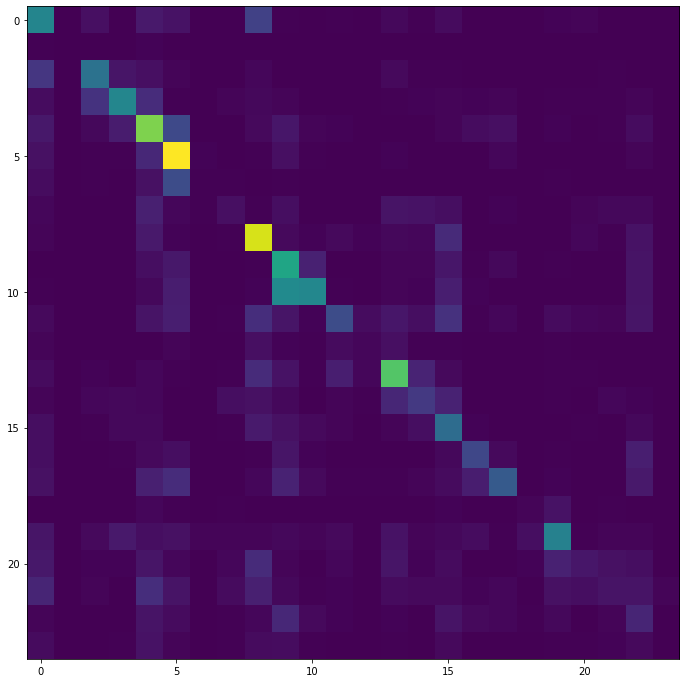

In [57]:
from sklearn.metrics import confusion_matrix

y_p = y_pred.reshape(-1,1)
y_true = y_test.reshape(-1,1)

cm = confusion_matrix(y_true,y_p)
misclassification_rate = 1-np.diagonal(cm).sum()/y_true.shape[0]
print(misclassification_rate)

from seaborn import heatmap

plt.figure(figsize=(12,12))
plt.imshow(cm)
plt.show()

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,X_test,y_pred)

ValueError: plot_confusion_matrix only supports classifiers

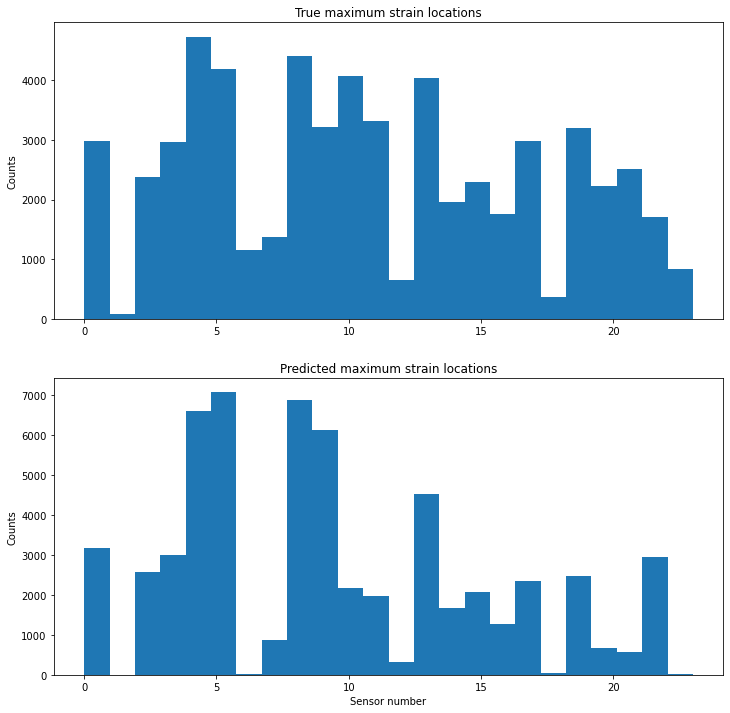

In [15]:
fig, ax = plt.subplots(2,figsize=(12,12))
ax[0].hist(y_true,bins=24)
ax[1].hist(y_p,bins=24)
ax[1].set_xlabel('Sensor number')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].set_title('True maximum strain locations')
ax[1].set_title('Predicted maximum strain locations')
plt.show()